# Machine Learning: Foundamentals - Project

Previsione di opportunità di Cross Sell di assicurazioni
Il cliente è una compagnia di assicurazioni che ha fornito un'assicurazione sanitaria ai suoi clienti, 
adesso hanno bisogno del tuo aiuto per costruire un modello predittivo in grado di prevedere se gli assicurati 
dell'anno passato potrebbero essere interessati ad acquistare anche un'assicurazione per il proprio veicolo.

Il dataset è composto dalle seguenti proprietà:

    - id: id univoco dell'acquirente.
    - Gender: sesso dell'acquirente.
    - Age: età dell'acquirente.
    - Driving_License: 1 se l'utente ha la patente di guida, 0 altrimenti.
    - Region_Code: codice univoco della regione dell'acquirente.
    - Previously_Insured: 1 se l'utente ha già un veicolo assicurato, 0 altrimenti.
    - Vehicle_Age: età del veicolo
    - Vehicle_Damage: 1 se l'utente ha danneggiato il veicolo in passato, 0 altrimenti.
    - Annual_Premium: la cifra che l'utente deve pagare come premio durante l'anno.
    - Policy_Sales_Channel: codice anonimizzato del canale utilizzato per la proposta 
    (es. per email, per telefono, di persona, ecc...)
    - Vintage: numero di giorni dalla quale l'utente è cliente dell'azienda.
    - Response: 1 se l'acquirente ha risposto positivamente alla proposta di vendita, 0 altrimenti.

L'obiettivo del modello è prevedere il valore di Response.

Tip Fai attenzione alla distribuzione delle classi, dai uno sguardo a questo approfondimento. 
In caso di classi sbilanciate puoi provare a:

    - Penalizzare la classe più frequente (ricorda l'argomento class_weight)
    - Utilizzare l'oversampling o l'undersampling.

In [1]:
pip install -U imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Imports of main libraries useful to the project
import pandas as pd
import numpy as np
from collections import Counter
from matplotlib import pyplot
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, RocCurveDisplay, log_loss
from sklearn.model_selection import train_test_split

np.set_printoptions(precision=2, suppress=True,floatmode="fixed")

In [3]:
def print_class_counts(feature_name, feature_series):
    print(f"\nCount of class {feature_name}: \n{feature_series.value_counts()} \n----------")

def plot_confusion_matrix(y_true, y_pred, labels=["Negative", "Positive"], show_precision=True, show_recall=True):

  cm = confusion_matrix(y_true, 
                        y_pred) # tn, fp, fn, tp 

  df_cm = pd.DataFrame(cm,
                       index = labels,
                       columns = ["Predicted "+labels[0],"Predicted "+labels[1]])
    
  sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')

def plot_histogram(X, feature_name):
    plt.hist(X, bins=20)
    plt.xlabel(f'{feature_name}')
    plt.ylabel('Frequency')
    plt.title(f'{feature_name} Distribution ')
    plt.show()

Two solution have been explored for this project:
1. Evaluate a logistic regression model using SMOTE algorithm used to generate syntetic data to balance the minority classes executing the oversampling.
2. Evaluate a logistic regression model using the class_weight parameter of fit method in order to penalize the majority classes.

The second solution returns an model with bad performance, above all to classify the new data relative to class 1 of target variable. 
For this reason, the best solution found is the number 1, where it has been used SMOTE algorithm to balance the data generating the new ones.

In [6]:
# First phase: Import dataset - for Train and Test
# Read the dataset and load it
df = pd.read_csv("C:\\Users\\39366\\Desktop\\Progetti - Master Data Science\\4 - Python Project - Assurance client classification\\train.csv", index_col=0)

# Show the first 5 rows of dataset
df.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [7]:
# Second phase: Data Preprocessing
# Explore the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 381109 entries, 1 to 381109
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  object 
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  float64
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  object 
 6   Vehicle_Damage        381109 non-null  object 
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  float64
 9   Vintage               381109 non-null  int64  
 10  Response              381109 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 34.9+ MB


In [8]:
# Check the shape of dataset
df.shape

(381109, 11)

In [9]:
# Summarize dataset information on position and varaibility indexes
df.describe()

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,38.822584,0.997869,26.388807,0.458210,30564.389581,112.034295,154.347397,0.122563
std,15.511611,0.046110,13.229888,0.498251,17213.155057,54.203995,83.671304,0.327936
min,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,25.000000,1.000000,15.000000,0.000000,24405.000000,29.000000,82.000000,0.000000
50%,36.000000,1.000000,28.000000,0.000000,31669.000000,133.000000,154.000000,0.000000
75%,49.000000,1.000000,35.000000,1.000000,39400.000000,152.000000,227.000000,0.000000
max,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


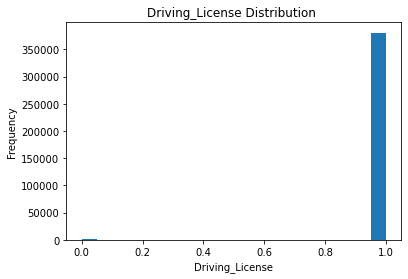

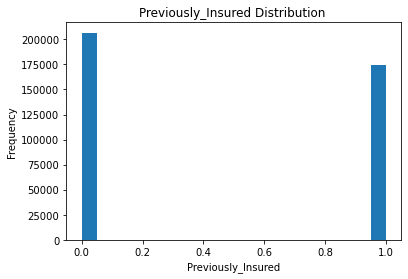

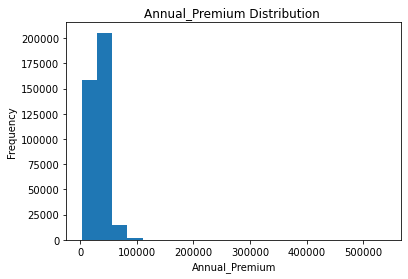

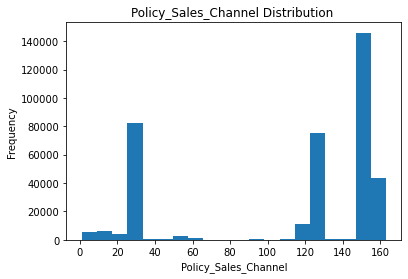

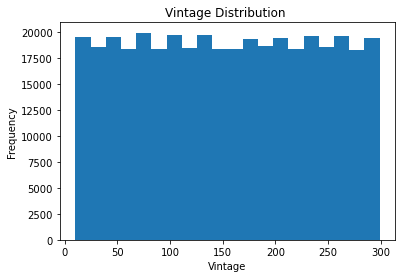

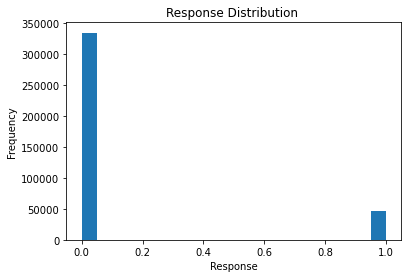

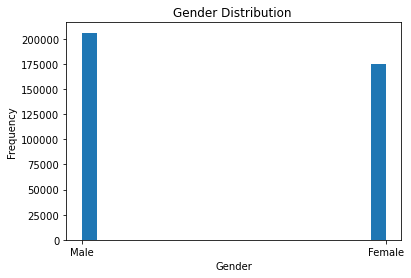

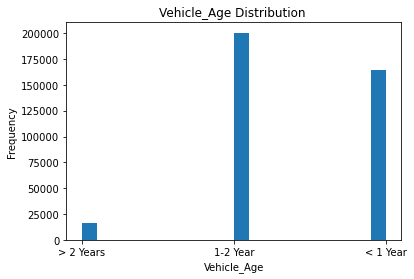

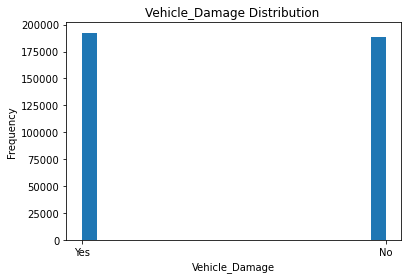

In [44]:
# Explore the features distribution
plot_histogram(df["Driving_License"], "Driving_License")
plot_histogram(df["Previously_Insured"], "Previously_Insured")
plot_histogram(df["Annual_Premium"], "Annual_Premium")
plot_histogram(df["Policy_Sales_Channel"], "Policy_Sales_Channel")
plot_histogram(df["Vintage"], "Vintage")
plot_histogram(df["Response"], "Response")
plot_histogram(df["Gender"], "Gender")
plot_histogram(df["Vehicle_Age"], "Vehicle_Age")
plot_histogram(df["Vehicle_Damage"], "Vehicle_Damage")

# Plotting the histograms the features it is possible to see that
# the features driving_license, vehicle_age, vehicle_damage and target feature response
# are unbalanced features

In [10]:
# Check if there are NaN values
df_na_values = df.isna()
df_na_values.sum()

# No NaN values are present

Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [11]:
# Check the balance of qualitative feature
# Gender, Vehicle_Age, Vehicle_Damage
print_class_counts("Gender", df["Gender"])
print_class_counts("Vehicle_Age", df["Vehicle_Age"])
print_class_counts("Vehicle_Damage", df["Vehicle_Damage"])
print_class_counts("Response", df["Response"])
print_class_counts("Previously_Insured", df["Previously_Insured"])
print_class_counts("Driving_License", df["Driving_License"])

# Vehicle_Age for >2 years, there are a few sample with it
# Response have got a few sample about value 1


Count of class Gender: 
Male      206089
Female    175020
Name: Gender, dtype: int64 
----------

Count of class Vehicle_Age: 
1-2 Year     200316
< 1 Year     164786
> 2 Years     16007
Name: Vehicle_Age, dtype: int64 
----------

Count of class Vehicle_Damage: 
Yes    192413
No     188696
Name: Vehicle_Damage, dtype: int64 
----------

Count of class Response: 
0    334399
1     46710
Name: Response, dtype: int64 
----------

Count of class Previously_Insured: 
0    206481
1    174628
Name: Previously_Insured, dtype: int64 
----------

Count of class Driving_License: 
1    380297
0       812
Name: Driving_License, dtype: int64 
----------


<AxesSubplot:>

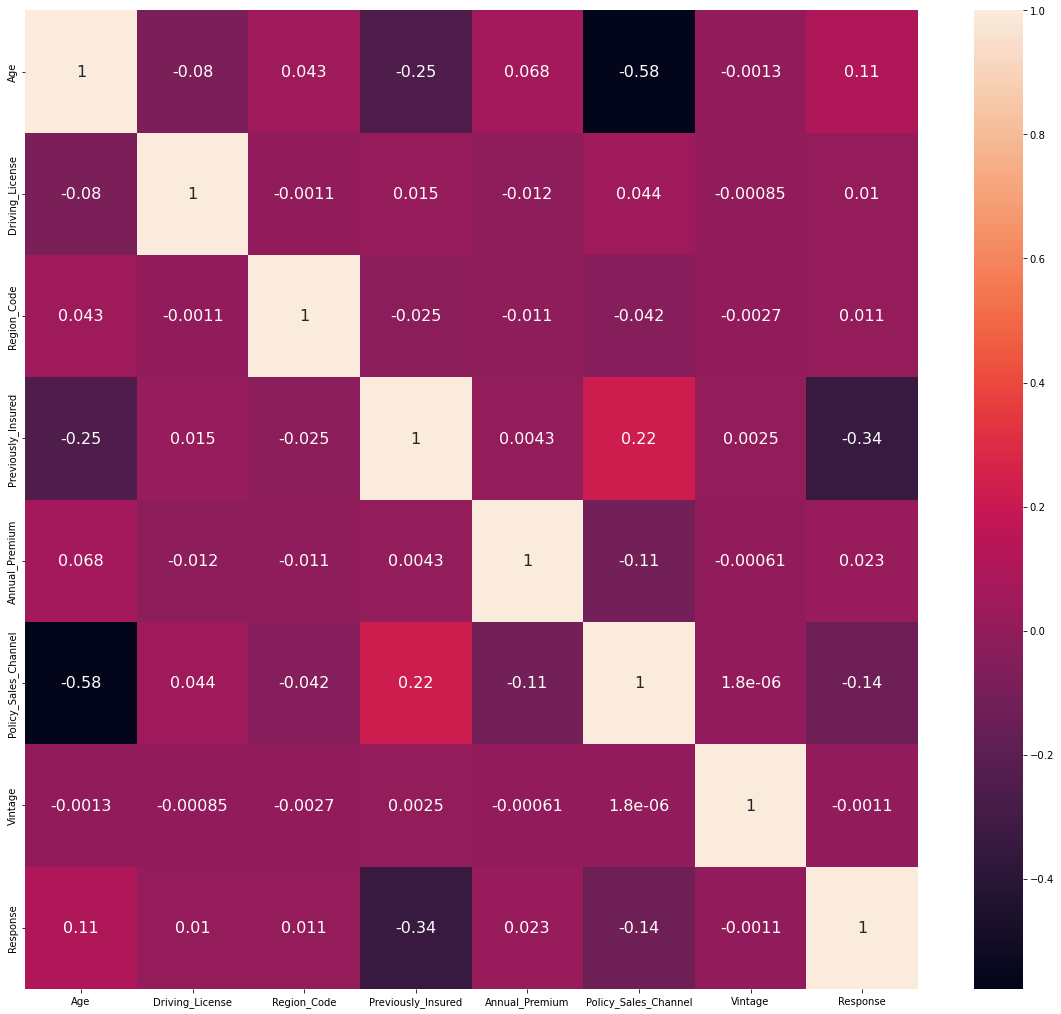

In [47]:
# Check correlation matrix in order to understand if there are multicollinearity
# and understand what features are revelant for the Response target variable
plt.figure(figsize=(20,18))
sns.heatmap(df.corr(), annot=True, annot_kws={"size":16})

# The correlation between features are veri slow, only a lower correlation
# between policy_sales_channel with Age, but it could be careless
# The correlation between features and target variable is very slow, near to 0
# that means there is no strong linear relation between them

In [14]:
# Into model are present 4 qualuitative feature then it is needed to execute the feature encoding
# Feature encoding for Gender, Vehicle_Age and Vehicle_Damage
encoded_Gender_train, _ = pd.factorize(df["Gender"])
encoded_Vehicle_Age_train, _ = pd.factorize(df["Vehicle_Age"])
encoded_Vehicle_Damage_train, _ = pd.factorize(df["Vehicle_Damage"])

# Replace the encoded variables into dataset
df["Gender"] = encoded_Gender_train
df["Vehicle_Age"] = encoded_Vehicle_Age_train
df["Vehicle_Damage"] = encoded_Vehicle_Damage_train

# Show the dataset changed
df

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
1,0,44,1,28.0,0,0,0,40454.0,26.0,217,1
2,0,76,1,3.0,0,1,1,33536.0,26.0,183,0
3,0,47,1,28.0,0,0,0,38294.0,26.0,27,1
4,0,21,1,11.0,1,2,1,28619.0,152.0,203,0
5,1,29,1,41.0,1,2,1,27496.0,152.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...
381105,0,74,1,26.0,1,1,1,30170.0,26.0,88,0
381106,0,30,1,37.0,1,2,1,40016.0,152.0,131,0
381107,0,21,1,30.0,1,2,1,35118.0,160.0,161,0


## First Solution: Generate synthetic data to balance the minority classes (SMOTE)

In [15]:
# Take from dataset the features and target variables
cols = df.columns
cols = cols.drop(["Response"])

X = df[cols]
y = df["Response"]

# Train and test split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

In [16]:
# To balance the features with few sample belong to minor classes
# apply the Synthetic Minority Over-sampling Technique
# in order to generate synthetic sampling to balance the minor classes


# Fit with data extracted the SMOTE algo in order to generate synthetic data
# and balance the features with minor classes
X_train, y_train = SMOTE(sampling_strategy='auto').fit_resample(X_train, y_train)

In [17]:
# Check if the target variable has been balanced
counter = Counter(y_train)
counter

Counter({0: 234308, 1: 234308})

In [18]:
# Feature scaling on test and train set
ss = StandardScaler()

X_train = ss.fit_transform(X_train)

print(f"Check the standardization" +
      F"\nTRAIN SET: \n Mean = {X_train.mean()} \n STD = {X_train.std()}" +
      F"\nTEST SET: \n Mean = {X_train.mean()} \n STD = {X_train.std()}")

Check the standardization
TRAIN SET: 
 Mean = -4.284584857022168e-17 
 STD = 1.0000000000000002
TEST SET: 
 Mean = -4.284584857022168e-17 
 STD = 1.0000000000000002


In [19]:
# Third phase: Model creation
# Create the logistic regression model
lr = LogisticRegression()

lr.fit(X_train, y_train)

LogisticRegression()

In [24]:
# Prediction with train and test data and relative probability prediction
y_pred_train = lr.predict(X_train)
y_proba_train = lr.predict_proba(X_train)
y_pred_test = lr.predict(X_test)
y_proba_test = lr.predict_proba(X_test)

C:\Users\39366\anaconda3\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\39366\anaconda3\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [25]:
# Fourth phase: Evaluate the model
# Calculate the Log Loss
print(f"TRAIN LOSS: {log_loss(y_train, y_proba_train)}")
print(f"TEST LOSS: {log_loss(y_test, y_proba_test)}")

# The Log Loss is low. It is equals to 0.38 that means the model does good prediction.

TRAIN LOSS: 0.37966672893764775
TEST LOSS: 13.558100384469405


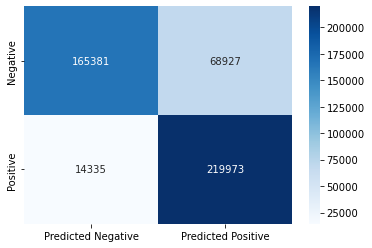

In [26]:
# Create the Confusion Matrix
plot_confusion_matrix(y_train, y_pred_train)

# True Positive: 220081
# False Positive: 69648
# True Negative: 164368
# False Negative: 14061

# Considering the number of True Positive and True Negative comparing with False Positive and False Negative
# the model could be good

In [27]:
# Create the report with main metrics: Precision, Recall and F1-Score
print("TRAIN REPORT")
print(classification_report(y_train, y_pred_train))
print("TEST REPORT")
print(classification_report(y_test, y_pred_test))

TRAIN REPORT
              precision    recall  f1-score   support

           0       0.92      0.71      0.80    234308
           1       0.76      0.94      0.84    234308

    accuracy                           0.82    468616
   macro avg       0.84      0.82      0.82    468616
weighted avg       0.84      0.82      0.82    468616

TEST REPORT
              precision    recall  f1-score   support

           0       0.89      0.29      0.44    100091
           1       0.13      0.73      0.22     14242

    accuracy                           0.35    114333
   macro avg       0.51      0.51      0.33    114333
weighted avg       0.79      0.35      0.41    114333



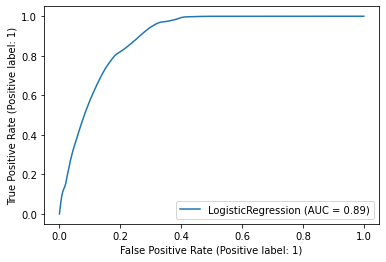

In [28]:
# Plot ROC for train set
RocCurveDisplay.from_estimator(lr, X_train, y_train)

C:\Users\39366\anaconda3\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


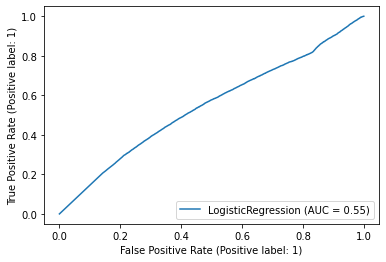

In [29]:
# Plot ROC for test set
RocCurveDisplay.from_estimator(lr, X_test, y_test)

## Second solution: Penalize minority classes

In [30]:
# Train and test split dataset
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(df[cols].values, df["Response"].values, test_size=.3)

In [31]:
# Feature scaling on test and train set
ss = StandardScaler()

X_train_2 = ss.fit_transform(X_train_2)

In [32]:
# Create logistic regression model with class_weight option
lr_class_balanced = LogisticRegression(class_weight="balanced")

lr_class_balanced.fit(X_train_2, y_train_2)

LogisticRegression(class_weight='balanced')

In [33]:
# Prediction with train and test data and relative probability prediction
y_pred_train_2 = lr_class_balanced.predict(X_train_2)
y_proba_train_2 = lr_class_balanced.predict_proba(X_train_2)
y_pred_test_2 = lr_class_balanced.predict(X_test_2)
y_proba_test_2 = lr_class_balanced.predict_proba(X_test_2)

In [34]:
# Fourth phase: Evaluate the model
# Calculate the Log Loss
print(f"TRAIN LOSS: {log_loss(y_train_2, y_proba_train_2)}")
print(f"TEST LOSS: {log_loss(y_test_2, y_proba_test_2)}")

# The Log Loss is high. It is equals to 0.5 that means the model is not really good for predictions.

TRAIN LOSS: 0.4905590678725307
TEST LOSS: 28.950565867669308


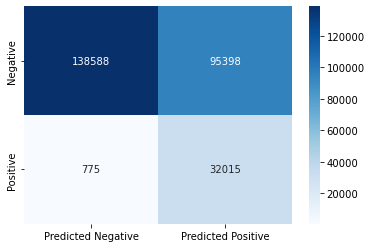

In [35]:
# Create the Confusion Matrix
plot_confusion_matrix(y_train_2, y_pred_train_2)

In [36]:
# Create the report with main metrics: Precision, Recall and F1-Score
print("TRAIN REPORT")
print(classification_report(y_train_2, y_pred_train_2))
print("TEST REPORT")
print(classification_report(y_test_2, y_pred_test_2))

# In particular, the precision for class 1 is too low and then for the class 0 is too high. 
# The model classify all the new data with response 0 and it is not good for the future predictions.

TRAIN REPORT
              precision    recall  f1-score   support

           0       0.99      0.59      0.74    233986
           1       0.25      0.98      0.40     32790

    accuracy                           0.64    266776
   macro avg       0.62      0.78      0.57    266776
weighted avg       0.90      0.64      0.70    266776

TEST REPORT
              precision    recall  f1-score   support

           0       1.00      0.00      0.00    100413
           1       0.12      1.00      0.22     13920

    accuracy                           0.12    114333
   macro avg       0.56      0.50      0.11    114333
weighted avg       0.89      0.12      0.03    114333



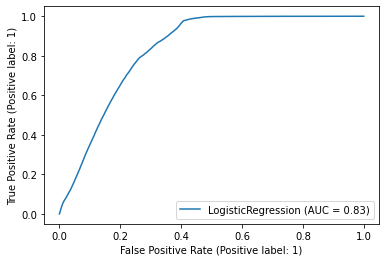

In [37]:
# Plot ROC for train set
RocCurveDisplay.from_estimator(lr_class_balanced, X_train_2, y_train_2)

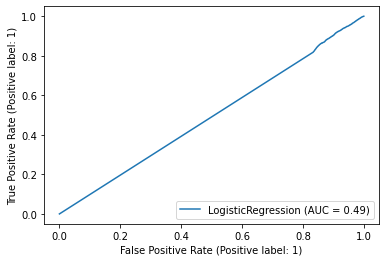

In [38]:
# Plot ROC for test set
RocCurveDisplay.from_estimator(lr_class_balanced, X_test_2, y_test_2)